# Exercise 3
### Lars Kuehmichel, Nicolas Wolf

### 1 Introduction


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d

import pandas as pd

In [2]:
mb_size = 100 # mini-batch size of 100
n_epochs = 101


trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))])


dataset = dset.MNIST("./", download = True,
                     train = True,
                     transform = trans)

test_dataset = dset.MNIST("./", download=True,
                          train=False,
                          transform = trans)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=mb_size,
                                         shuffle=True, num_workers=15,
                                         pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=mb_size,
                                          shuffle=True, num_workers=15,
                                          pin_memory=True)

In [3]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w

def init_weights_cuda(shape):
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w = w.cuda()
    w.requires_grad = True
    return w


def rectify(X):
    return torch.max(torch.zeros_like(X), X)

In [4]:
# this is an example as a reduced version of the pytorch internal RMSprop optimizer
class RMSprop(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1-alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])

In [5]:
def model(X, w_h, w_h2, w_o, train=False):
    h = rectify(X @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


w_h = init_weights_cuda((784, 625))
w_h2 = init_weights_cuda((625, 625))
w_o = init_weights_cuda((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o])

In [6]:
def train(model, optimizer, n_epochs, batch_size, model_args=()):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # put this into a training loop over n epochs
    for i in range(n_epochs):
        print("Epoch: {}".format(i+1))
        train_loss = 0
        correct_train = []
        test_loss = 0
        correct_test = []
        j = 0
        for (j, (X, y)) in enumerate(dataloader):
            X = X.reshape(batch_size, -1)
            X = X.cuda()
            y = y.cuda()

            optimizer.zero_grad(set_to_none=True)
            noise_py_x = model(X, *model_args, train=True)

            # the cross-entropy loss function already contains the softmax
            cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
            cost.backward()
            optimizer.step()

            train_loss += cost
            train_labels = torch.argmax(noise_py_x, dim=-1)
            correct = (y == train_labels).detach().cpu().numpy()
            correct_train.append(correct)

        # no need to calculate gradients for validation
        with torch.no_grad():
            k = 0
            for (k, (X, y)) in enumerate(test_loader):
                X = X.reshape(batch_size, -1)
                X = X.cuda()
                y = y.cuda()

                noise_py_x = model(X, *model_args, train=False)
                cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
                test_loss += cost
                test_labels = torch.argmax(noise_py_x, dim=-1)
                correct = (y == test_labels).detach().cpu().numpy()
                correct_test.append(correct)

        train_losses.append(train_loss / (j + 1))
        train_accuracies.append(np.mean(correct_train))
        test_losses.append(test_loss / (k + 1))
        test_accuracies.append(np.mean(correct_test))

        if i % 10 == 0:
            print(f"Average Train Loss: {sum(train_losses) / (i + 1)}")
            print(f"Average Test Loss: {sum(test_losses) / (i + 1)}")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [7]:
train_loss, train_accuracy, test_loss, test_accuracy = train(
    model,
    optimizer,
    n_epochs=n_epochs,
    batch_size=mb_size,
    model_args=(w_h, w_h2, w_o)
)

Epoch: 1
Average Train Loss: 0.3958974778652191
Average Test Loss: 0.16351032257080078
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 0.19974641501903534
Average Test Loss: 0.23767352104187012
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Average Train Loss: 0.166105255484581
Average Test Loss: 0.2982325851917267
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Average Train Loss: 0.1410999745130539
Average Test Loss: 0.3500877320766449
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Average Train Loss: 0.12133125960826874
Average Test Loss: 0.41168928146362305
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Average Train Loss: 0.10678256303071976
Average Test Loss: 0.4618223011493683
Epoch: 52
Epoch: 53
Epoch: 54
Ep

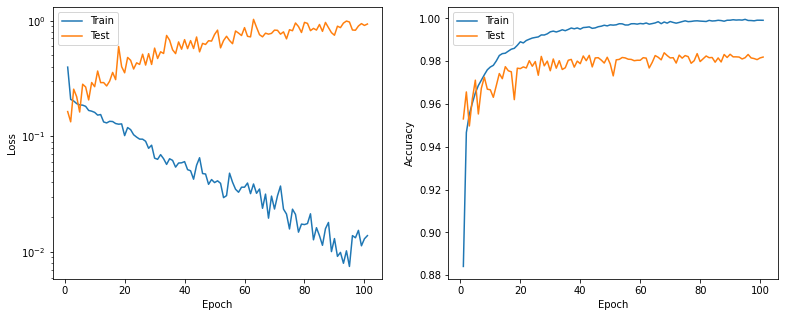

In [8]:
epochs = 1 + np.arange(len(train_loss))

_, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(epochs, train_loss, label="Train")
axes[0].plot(epochs, test_loss, label="Test")
axes[1].plot(epochs, train_accuracy, label="Train")
axes[1].plot(epochs, test_accuracy, label="Test")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_yscale("log")
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

### 2 Dropout

Dropout randomly sets parts of the network to inactive (i.e. zero) during training.
This means that the network cannot train to overly rely on very specific neuron connections,
thus reducing overfitting.

We can see that without dropout, the training loss steadily decreases, whereas the validation
loss increases after the first few epochs. This means the model is overfitting.

With dropout, the model does not sufficiently fit to the data. This is likely because the model must
be big enough to still be able to classify instances somewhat well when half of the neurons are
disabled. The test accuracy also steadily decreases, and is at around $90\%$ at the end of training.

The model could be locally diverging due to the overall low classification accuracy in training,
which could lead to this result. The solution would be to schedule the learning rate, and increase
the complexity of the model.

However, it is visible that the model is much more resistant to overfitting. The test loss
increases by a factor of roughly $3$ during training, which is small when compared to the
factor of around $8$ from before.

Training accuracy with dropout is significantly lower than test accuracy, since dropout is disabled
while testing, which allows the network to use its full capacity.

In [9]:
def dropout(X, p_drop=0.5, train=False):
    # dropout is disabled in validation
    if train and (0 < p_drop < 1):
        # rand_like gives errors for some dtypes
        r = torch.rand(X.shape)
        keep = (r >= p_drop).cuda()
        result = (X * keep) / (1 - p_drop)
        return result
    return X

# test this
X = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
]).cuda()

X = dropout(X, train=True)

# works fine
print(X)


def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden, train=False):
    h = dropout(X @ w_h, p_drop_input, train=train)
    h2 = rectify(h)
    h3 = dropout(h2 @ w_h2, p_drop_hidden, train=train)
    h4 = rectify(h3)
    h5 = dropout(h4 @ w_o, p_drop_hidden, train=train)
    pre_softmax = h5
    return pre_softmax

p_drop_input = 0.5
p_drop_hidden = 0.5

tensor([[ 2.,  0.,  0.,  0.],
        [ 0., 12., 14., 16.],
        [ 0., 20., 22., 24.]], device='cuda:0')


Reinitialize weights randomly

In [10]:
w_h = init_weights_cuda(w_h.shape)
w_h2 = init_weights_cuda(w_h2.shape)
w_o = init_weights_cuda(w_o.shape)

optimizer = RMSprop([w_h, w_h2, w_o])

#### Training the Dropout Model

In [11]:
train_loss_d, train_accuracy_d, test_loss_d, test_accuracy_d = train(
    dropout_model,
    optimizer,
    n_epochs=n_epochs,
    batch_size=mb_size,
    model_args=(
        w_h,
        w_h2,
        w_o,
        p_drop_input,
        p_drop_hidden,
    )
)

Epoch: 1
Average Train Loss: 1.4982812404632568
Average Test Loss: 0.3234124779701233
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 1.428071141242981
Average Test Loss: 0.2992238700389862
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Average Train Loss: 1.5118563175201416
Average Test Loss: 0.32735058665275574
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Average Train Loss: 1.5736249685287476
Average Test Loss: 0.36479493975639343
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Average Train Loss: 1.6357954740524292
Average Test Loss: 0.3940642178058624
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Average Train Loss: 1.6884896755218506
Average Test Loss: 0.42169561982154846
Epoch: 52
Epoch: 53
Epoch: 54
Epoch

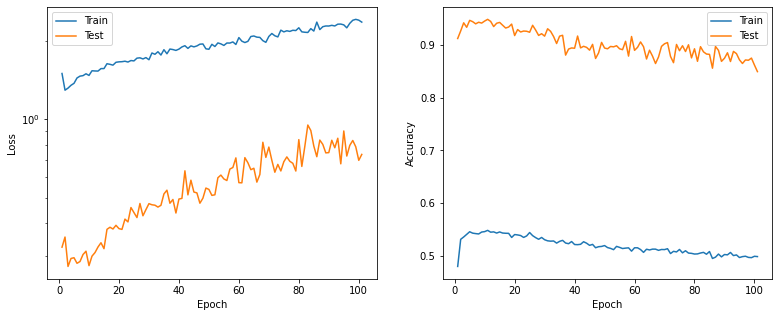

In [12]:
epochs = 1 + np.arange(len(train_loss_d))

_, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(epochs, train_loss_d, label="Train")
axes[0].plot(epochs, test_loss_d, label="Test")
axes[1].plot(epochs, train_accuracy_d, label="Train")
axes[1].plot(epochs, test_accuracy_d, label="Test")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_yscale("log")
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

### 3 Parametric ReLU

This model has increased complexity, which shows in the results. It fits quickly, does not significantly
overfit and can classify the dataset well, when compared to the previous models.

In [13]:
def PRelu(X, a):
    return torch.where(X > 0, X, a * X)


def prelu_model(X, a, w_h, w_h2, w_o, p_drop_input, p_drop_hidden, train=False):
    h = dropout(X @ w_h, p_drop_input, train=train)
    h2 = PRelu(h, a)
    h3 = dropout(h2 @ w_h2, p_drop_hidden, train=train)
    h4 = PRelu(h3, a)
    h5 = dropout(h4 @ w_o, p_drop_hidden, train=train)
    pre_softmax = h5
    return pre_softmax


In [14]:
a = init_weights_cuda((1, 625))
w_h = init_weights_cuda(w_h.shape)
w_h2 = init_weights_cuda(w_h2.shape)
w_o = init_weights_cuda(w_o.shape)

param_optimizer = RMSprop([a, w_h, w_h2, w_o])


In [15]:
train_loss_p, train_accuracy_p, test_loss_p, test_accuracy_p = train(
    prelu_model,
    param_optimizer,
    n_epochs=n_epochs,
    batch_size=mb_size,
    model_args=(
        a,
        w_h,
        w_h2,
        w_o,
        p_drop_input,
        p_drop_hidden,
    )
)

Epoch: 1
Average Train Loss: 3.7880637645721436
Average Test Loss: 0.8340935111045837
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 1.7698163986206055
Average Test Loss: 0.3390439748764038
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Average Train Loss: 1.5497698783874512
Average Test Loss: 0.27482870221138
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Average Train Loss: 1.4496031999588013
Average Test Loss: 0.24153956770896912
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Average Train Loss: 1.3865588903427124
Average Test Loss: 0.22267107665538788
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Average Train Loss: 1.3416410684585571
Average Test Loss: 0.21033386886119843
Epoch: 52
Epoch: 53
Epoch: 54
Epoch:

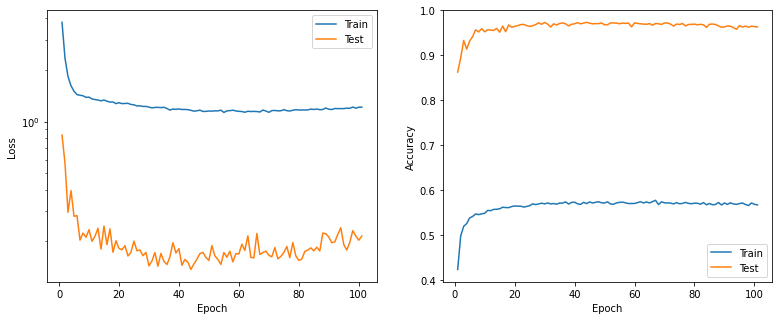

In [16]:
epochs = 1 + np.arange(len(train_loss_p))

_, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(epochs, train_loss_p, label="Train")
axes[0].plot(epochs, test_loss_p, label="Test")
axes[1].plot(epochs, train_accuracy_p, label="Train")
axes[1].plot(epochs, test_accuracy_p, label="Test")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_yscale("log")
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()


### 4 Convolutional Layers

#### 4.1 Create a Convolutional Network

The convolutional model reaches a better accuracy than the purely parametric model. The test loss
is much more volatile, but never significantly higher than with previous models.

This model does not make use of the full input data, as will be explained under $4.2$.

In [17]:
def custom_conv2d(in_channels, out_channels, kernel_size, p_dropout):
    # define a custom convolutional layer with
    # dropout, conv2d, prelu activation and maxpooling
    # also takes care of weight initialization
    drop = torch.nn.Dropout(p=p_dropout)
    conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
    conv.weight = torch.nn.Parameter(init_weights((out_channels, in_channels, *kernel_size)))
    prelu = torch.nn.PReLU(num_parameters=out_channels)
    prelu.weight = torch.nn.Parameter(init_weights((out_channels,)))
    # the sample code implicitly sets stride=(2, 2)
    maxpool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    return torch.nn.Sequential(
        drop,
        conv,
        prelu,
        maxpool
    )

def dense(in_features, out_features):
    # same as custom_conv2d but for fully connected layers
    linear = torch.nn.Linear(in_features=in_features, out_features=out_features)
    prelu = torch.nn.PReLU(num_parameters=out_features)
    prelu.weight = torch.nn.Parameter(init_weights((out_features,)))

    return torch.nn.Sequential(
        linear,
        prelu
    )

In [18]:
# 128 filters, 1x1 image
n_out_px = 128

p_drop_input = 0.25
p_drop_hidden = 0.25

# in_features are given by the preceding layer
conv_model = torch.nn.Sequential(
    custom_conv2d(in_channels=1, out_channels=32,
                  kernel_size=(5, 5), p_dropout=p_drop_input),
    custom_conv2d(in_channels=32, out_channels=64,
                  kernel_size=(5, 5), p_dropout=p_drop_hidden),
    custom_conv2d(in_channels=64, out_channels=128,
                  kernel_size=(2, 2), p_dropout=p_drop_hidden),
    torch.nn.Flatten(),
    dense(in_features=n_out_px, out_features=784),
    # same layer sizes as before
    dense(in_features=784, out_features=625),
    dense(in_features=625, out_features=625),
    # linear (pre-softmax) output layer
    torch.nn.Linear(in_features=625, out_features=10)
)

conv_model = conv_model.cuda()

conv_optimizer = torch.optim.RMSprop(
    conv_model.parameters(),
    # ensure same hyper-parameters as before for comparability
    lr=1e-3,
    alpha=0.5,
    eps=1e-8
)

conv_loss = torch.nn.CrossEntropyLoss(reduction="mean").cuda()

In [19]:
def train_conv(model, optimizer, loss, n_epochs, shape):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(n_epochs):
        train_loss = 0
        correct_train = []
        test_loss = 0
        correct_test = []

        model.train(mode=True)
        for i, (x, ystar) in enumerate(dataloader):
            x = x.reshape(shape)
            x = x.cuda()
            ystar = ystar.cuda()
            optimizer.zero_grad()
            yhat = model(x)
            l = loss(yhat, ystar)
            l.backward()
            optimizer.step()

            # add float value of the loss
            train_loss += l.detach().item()
            train_labels = torch.argmax(yhat, dim=-1)
            correct = (ystar == train_labels).detach()
            correct = correct.cpu().numpy()
            correct_train.append(correct)

        model.train(mode=False)
        with torch.no_grad():
            for j, (x, ystar) in enumerate(test_loader):
                x = x.reshape(shape)
                x = x.cuda()
                ystar = ystar.cuda()
                yhat = model(x)
                l = loss(yhat, ystar)

                test_loss += l.detach().item()
                test_labels = torch.argmax(yhat, dim=-1)
                correct = (ystar == test_labels).detach()
                correct = correct.cpu().numpy()
                correct_test.append(correct)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1} / {n_epochs}")

        train_losses.append(train_loss / (i + 1))
        train_accuracies.append(np.mean(correct_train))
        test_losses.append(test_loss / (j + 1))
        test_accuracies.append(np.mean(correct_test))
    return train_losses, train_accuracies, test_losses, test_accuracies


#### 4.2 Application of Convolutional Network

In [20]:
train_loss_c, train_accuracy_c, test_loss_c, test_accuracy_c = train_conv(
    conv_model,
    conv_optimizer,
    conv_loss,
    n_epochs=n_epochs,
    shape=(-1, 1, 28, 28)
)

Epoch 1 / 101
Epoch 11 / 101
Epoch 21 / 101
Epoch 31 / 101
Epoch 41 / 101
Epoch 51 / 101
Epoch 61 / 101
Epoch 71 / 101
Epoch 81 / 101
Epoch 91 / 101
Epoch 101 / 101


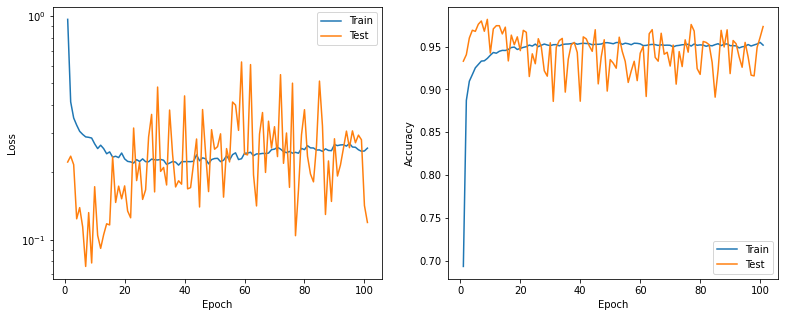

In [21]:
epochs = 1 + np.arange(len(train_loss_c))

_, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(epochs, train_loss_c, label="Train")
axes[0].plot(epochs, test_loss_c, label="Test")
axes[1].plot(epochs, train_accuracy_c, label="Train")
axes[1].plot(epochs, test_accuracy_c, label="Test")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_yscale("log")
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()


#### Visualizations

Target Label: 8


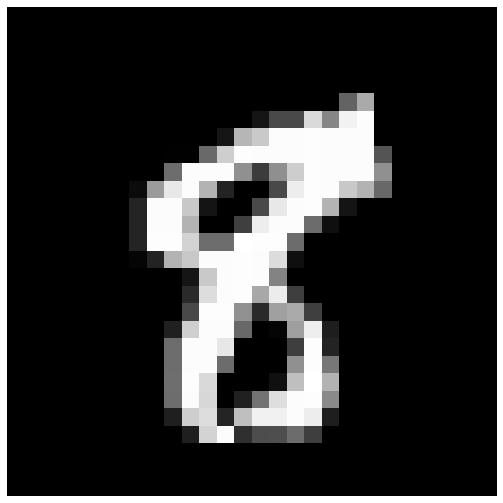

In [22]:
test_image, test_label = next(iter(dataloader))

# one image, one channel, 28x28 px
test_image = test_image[0].reshape(1, 1, 28, 28)
test_label = test_label[0].item()
print("Target Label:", test_label)

plt.figure(figsize=(10, 9))
# only the 28x28 px information here
plt.imshow(test_image[0][0], cmap="gray")
plt.axis("off")
plt.show()


#### Filtered Images

Images where the filter responds to a single pixel are very sharp.

Images where the filter responds to a region of pixels are blurry.

Images are inverted if the filter is inverted.

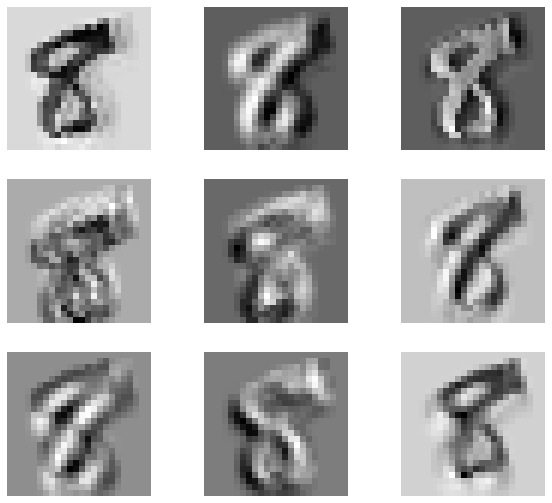

In [23]:
modules = [module for module in conv_model.modules() if not isinstance(module, torch.nn.Sequential)]

convolution = modules[1].cpu()

convoluted_image = convolution(test_image)

plt.figure(figsize=(10, 9))
for i in range(9):
    img = convoluted_image[0][i].detach().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()


#### Corresponding Filter Weights

Most filters heavily rely on a single pixel of the input image.
Some rely heavily on a single region of pixels.

Filters that look "inverted" with respect to one another may have
the same effect, with negative weights in the next layer.
More explicitly, it does not matter if the filter is black with a
white pixel, or white with a black pixel, since this only changes
the sign of the filter's output.

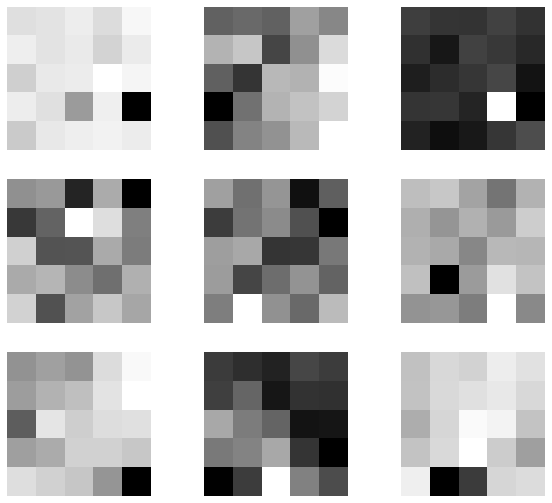

In [24]:
plt.figure(figsize=(10, 9))
for i in range(9):
    img = convolution.weight[i][0].detach().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()


#### Modifying the Network

We decided to increase the filter size of the first convolutional layer. We also adjusted the other
layers filter sizes such that all information from the original image is used in the dense part of the nn.

Explanation: In the original network, the convolutional filter of kernel size (2x2) yields an input
for the final maxpool layer with uneven pixel number. This means the maxpool will ignore the final
line and row of this input. This problem is avoided here since the data sizes are:

$
\newcommand{\conv}{\stackrel{conv}{\rightarrow}}
\newcommand{\maxpool}{\stackrel{max}{\rightarrow}}
(1, 28, 28) \conv (32, 22, 22) \maxpool (32, 11, 11) \conv (64, 8, 8) \maxpool (64, 4, 4) \conv (128, 2, 2) \maxpool (128, 1, 1)
$

Where the final two dimensions of the data are both always even before being passed into a maxpool.


The test error is significantly improved. Results see below.

In [25]:
# 128 channels, 1x1 image
n_out_px = 128

modified_conv_model = torch.nn.Sequential(
    custom_conv2d(in_channels=1, out_channels=32,
                  kernel_size=(7, 7), p_dropout=p_drop_input),
    custom_conv2d(in_channels=32, out_channels=64,
                  kernel_size=(4, 4), p_dropout=p_drop_hidden),
    custom_conv2d(in_channels=64, out_channels=128,
                  kernel_size=(3, 3), p_dropout=p_drop_hidden),
    torch.nn.Flatten(),
    dense(in_features=n_out_px, out_features=784),
    # same layer sizes as before
    dense(in_features=784, out_features=625),
    dense(in_features=625, out_features=625),
    # linear (pre-softmax) output layer
    torch.nn.Linear(in_features=625, out_features=10)
)

modified_conv_model = modified_conv_model.cuda()

modified_conv_optimizer = torch.optim.RMSprop(
    modified_conv_model.parameters(),
    # ensure same hyper-parameters as before for comparability
    lr=1e-3,
    alpha=0.5,
    eps=1e-8
)

# this is already on the GPU
modified_conv_loss = conv_loss

In [26]:
train_loss_mc, train_accuracy_mc, test_loss_mc, test_accuracy_mc = train_conv(
    modified_conv_model,
    modified_conv_optimizer,
    modified_conv_loss,
    n_epochs=n_epochs,
    shape=(-1, 1, 28, 28)
)

Epoch 1 / 101
Epoch 11 / 101
Epoch 21 / 101
Epoch 31 / 101
Epoch 41 / 101
Epoch 51 / 101
Epoch 61 / 101
Epoch 71 / 101
Epoch 81 / 101
Epoch 91 / 101
Epoch 101 / 101


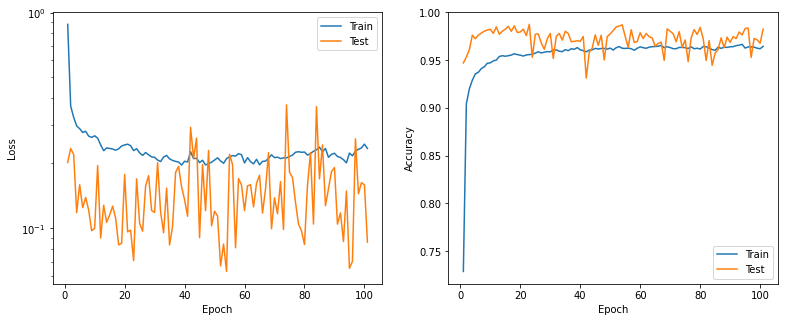

In [27]:
epochs = 1 + np.arange(len(train_loss_mc))

_, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(epochs, train_loss_mc, label="Train")
axes[0].plot(epochs, test_loss_mc, label="Test")
axes[1].plot(epochs, train_accuracy_mc, label="Train")
axes[1].plot(epochs, test_accuracy_mc, label="Test")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_yscale("log")
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

#### Visualizing the Modified Network

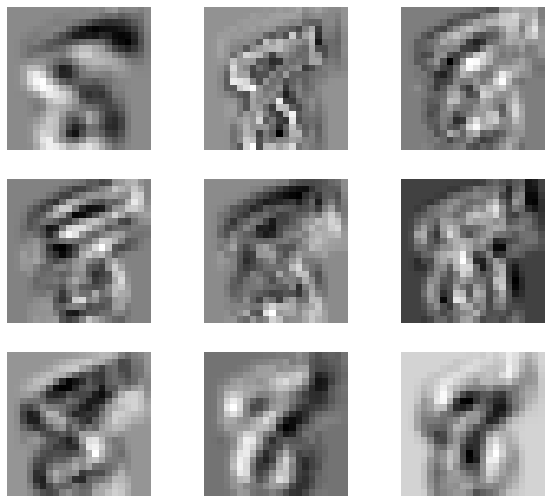

In [28]:
modules = [module for module in modified_conv_model.modules() if not isinstance(module, torch.nn.Sequential)]

convolution = modules[1].cpu()

convoluted_image = convolution(test_image)

plt.figure(figsize=(10, 9))
for i in range(9):
    img = convoluted_image[0][i].detach().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

Filters tend to be more complex than before. Instead of activating strongly on single pixels,
we can see more complex shapes here, like the back arch of a 7, or part of a 0. This means the
filters will pick up more macroscopic features in the images.

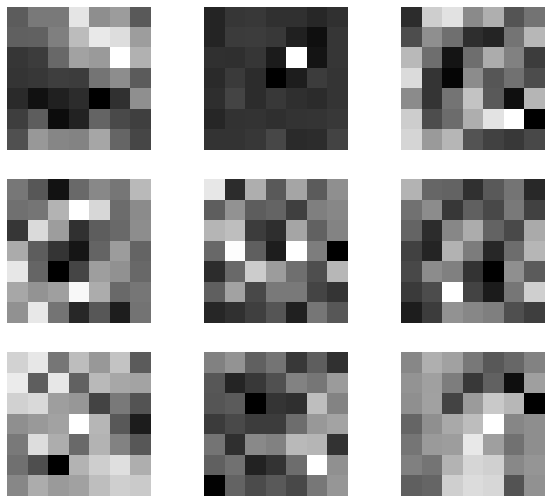

In [29]:
plt.figure(figsize=(10, 9))
for i in range(9):
    img = convolution.weight[i][0].detach().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()


#### Error and Loss Overview

The MLP performs okay in loss, and best in accuracy. This highlights the overfitting,
since the MLP is often correct, but likely too sure of its choices in ambiguous cases.

The dropout model does not perform particularly well due to the aforementioned reasons.

The parametric model performs well.

The convolutional model performs well, but is below the MLP in accuracy. This is likely
because it does not use the full input data, as mentioned before.

The modified convolutional net performs best in loss and second best in accuracy.

In [92]:
line_names = ["Train", "Test"]
column_names = ["MLP", "Dropout", "Param", "Conv", "ModConv"]

# mean over the last 20 epochs
def fetch(a):
    n_epochs = 20
    a = a[-n_epochs:]
    if isinstance(a[0], torch.Tensor):
        a = [a.cpu().detach().numpy() for a in a[-n_epochs:]]
    return np.mean(a).astype(float)

accuracy_arrays = [
    [train_accuracy, train_accuracy_d, train_accuracy_p, train_accuracy_c, train_accuracy_mc],
    [test_accuracy, test_accuracy_d, test_accuracy_p, test_accuracy_c, test_accuracy_mc]
]

loss_arrays = [
    [train_loss, train_loss_d, train_loss_p, train_loss_c, train_loss_mc],
    [test_loss, test_loss_d, test_loss_p, test_loss_c, test_loss_mc]
]

accuracies = np.array([
    [fetch(a) for a in accuracy_arrays[0]],
    [fetch(a) for a in accuracy_arrays[1]]
])

losses = np.array([
    [fetch(a) for a in loss_arrays[0]],
    [fetch(a) for a in loss_arrays[1]]
])

#### Loss (lower is better)

In [93]:
loss_df = pd.DataFrame(losses, index=line_names, columns=column_names)

print(loss_df)

            MLP   Dropout     Param      Conv   ModConv
Train  0.012927  2.287730  1.188289  0.257217  0.224303
Test   0.879747  0.793353  0.200809  0.245319  0.158356


#### Accuracy (higher is better)

In [94]:
accuracy_df = pd.DataFrame(accuracies, index=line_names, columns=column_names)

print(accuracy_df)

            MLP   Dropout     Param      Conv   ModConv
Train  0.999031  0.500464  0.568841  0.951498  0.963394
Test   0.981635  0.876515  0.964525  0.942030  0.968885


#### Accuracy Score (higher is better)

This just makes accuracy numbers easier to comprehend for caveman brains, and is not suitable for a
quantitative analysis.

In [95]:
score_df = 1 / (1 - accuracy_df)

print(score_df)


               MLP   Dropout      Param       Conv   ModConv
Train  1031.814273  2.001858   2.319329  20.617848  27.31805
Test     54.451402  8.098150  28.188865  17.250302  32.13884
